<a href="https://colab.research.google.com/github/Shaurya0108/cs4372/blob/main/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install yfinance pandas numpy matplotlib

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [7]:
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date, interval='1mo')
    return df['Close']

In [8]:
def calculate_sma_signal(prices, n_months=10):
    sma = prices.rolling(window=n_months).mean()
    signal = np.where(prices > sma, 1, 0)
    return pd.Series(signal, index=prices.index)

In [9]:
def buy_and_hold_strategy(prices, monthly_investment=1000):
    equity = []
    units = []
    current_units = 0

    for price in prices:
        current_units += monthly_investment / price
        equity.append(current_units * price)
        units.append(current_units)

    return pd.Series(equity, index=prices.index)

In [10]:
def active_trading_strategy(prices, signals, monthly_investment=1000):
    equity = []
    units = []
    cash = []
    current_units = 0
    current_cash = 0

    for i, (price, signal) in enumerate(zip(prices, signals)):
        if i == 0:
            if signal == 1:
                current_units = monthly_investment / price
                current_cash = 0
            else:
                current_units = 0
                current_cash = monthly_investment
        else:
            prev_signal = signals.iloc[i-1]

            if signal == 1:
                if prev_signal == 0:
                    current_units = (current_cash + monthly_investment) / price
                    current_cash = 0
                else:
                    current_units += monthly_investment / price
                    current_cash = 0
            else:
                if prev_signal == 1:
                    current_cash = current_units * price + monthly_investment
                    current_units = 0
                else:
                    current_cash += monthly_investment
                    current_units = 0

        equity.append(current_units * price + current_cash)
        units.append(current_units)
        cash.append(current_cash)

    return pd.Series(equity, index=prices.index)

In [11]:
def calculate_annual_return(final_value, total_invested, years):
    """Calculate annualized return based on total invested amount"""
    if total_invested == 0:
        return 0
    return (((final_value / total_invested) ** (1/years)) - 1) * 100

In [12]:
ticker = "SPY"
end_date = datetime.now()
start_date = end_date - timedelta(days=365*30)
monthly_investment = 1000

prices = fetch_stock_data(ticker, start_date, end_date)
signals = calculate_sma_signal(prices)

bh_equity = buy_and_hold_strategy(prices, monthly_investment)
at_equity = active_trading_strategy(prices, signals, monthly_investment)

years = (prices.index[-1] - prices.index[0]).days / 365
total_invested = monthly_investment * len(prices)

bh_final_equity = bh_equity.iloc[-1]
bh_annual_return = calculate_annual_return(bh_final_equity, total_invested, years)

at_final_equity = at_equity.iloc[-1]
at_annual_return = calculate_annual_return(at_final_equity, total_invested, years)

In [13]:
print(f"\nBuy and Hold Strategy:")
print(f"Total Invested: ${total_invested:,.2f}")
print(f"Final Equity: ${bh_final_equity:,.2f}")
print(f"Annual Return: {bh_annual_return:.2f}%")

print(f"\nActive Trading Strategy:")
print(f"Total Invested: ${total_invested:,.2f}")
print(f"Final Equity: ${at_final_equity:,.2f}")
print(f"Annual Return: {at_annual_return:.2f}%")


Buy and Hold Strategy:
Total Invested: $359,000.00
Final Equity: $2,208,994.41
Annual Return: 6.28%

Active Trading Strategy:
Total Invested: $359,000.00
Final Equity: $1,657,762.66
Annual Return: 5.26%


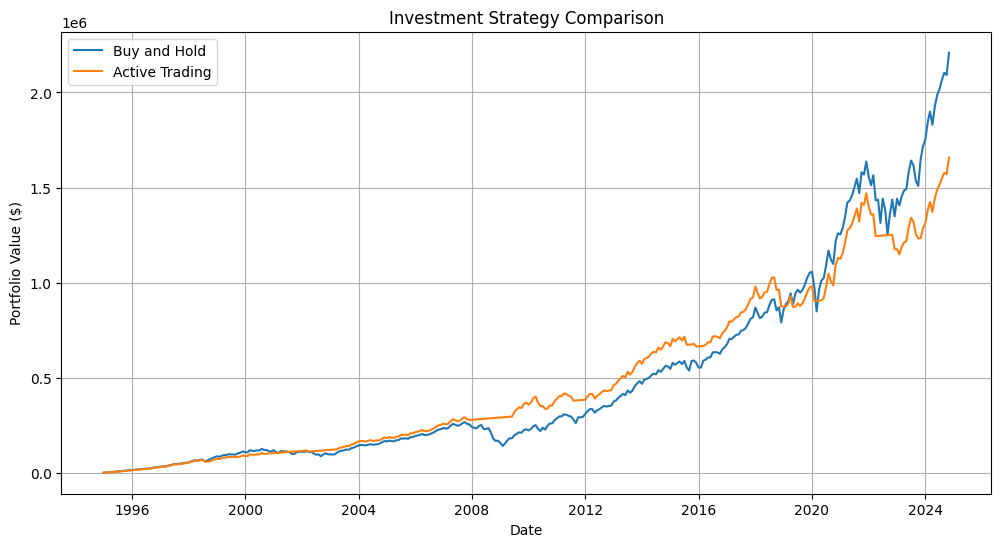

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(bh_equity.index, bh_equity.values, label='Buy and Hold')
plt.plot(at_equity.index, at_equity.values, label='Active Trading')
plt.title('Investment Strategy Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()